# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [505]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [506]:
df_dropped = df.drop('diagnosis', axis=1)
df_dropped.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [0]:
# Perform K-Means Clustering on the Dataset

In [508]:
# check for null values
df_dropped.isnull().sum()

id                           0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: i

In [0]:
# drop column with nan values
df_dropped = df_dropped.drop(['Unnamed: 32'], axis=1)

In [510]:
# create list of data frame column
df_dropped.columns.to_list()

['id',
 'radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

No handles with labels found to put in legend.


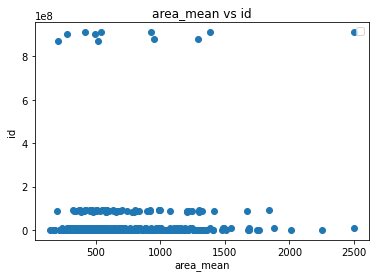

No handles with labels found to put in legend.


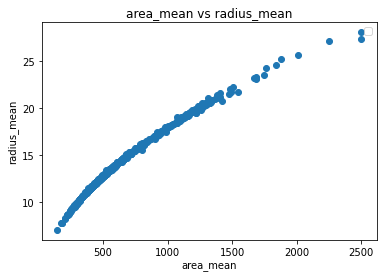

No handles with labels found to put in legend.


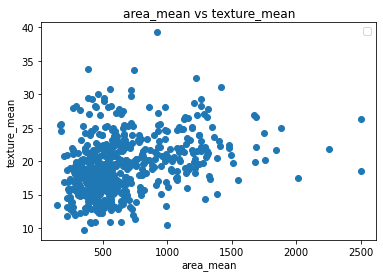

No handles with labels found to put in legend.


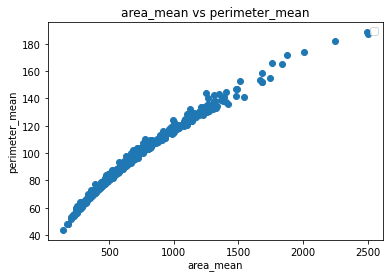

No handles with labels found to put in legend.


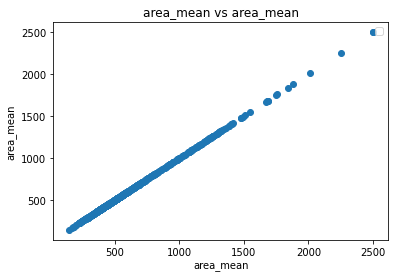

No handles with labels found to put in legend.


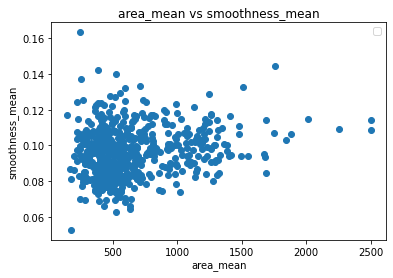

No handles with labels found to put in legend.


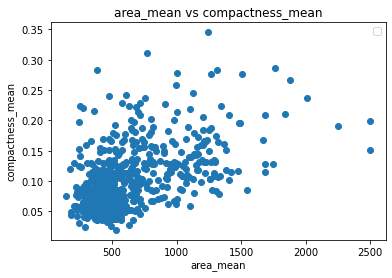

No handles with labels found to put in legend.


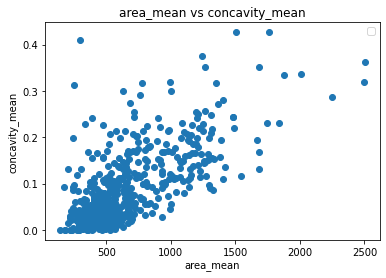

No handles with labels found to put in legend.


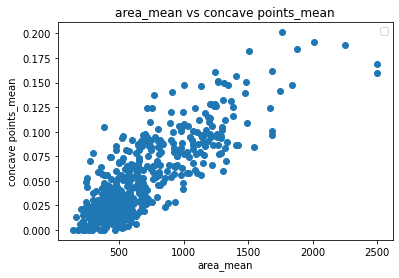

No handles with labels found to put in legend.


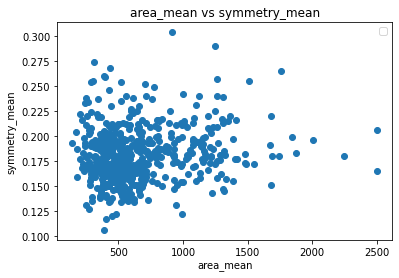

No handles with labels found to put in legend.


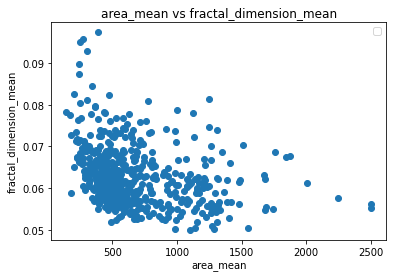

No handles with labels found to put in legend.


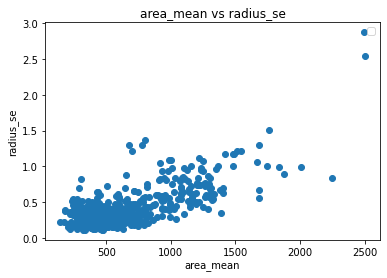

No handles with labels found to put in legend.


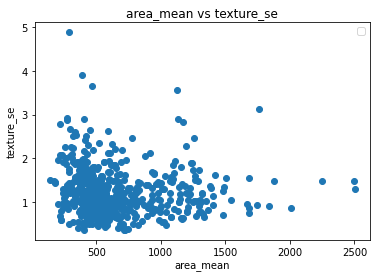

No handles with labels found to put in legend.


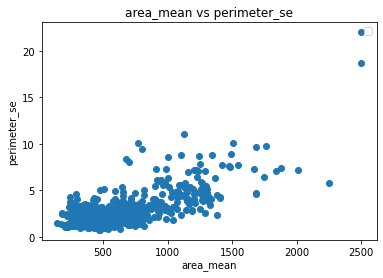

No handles with labels found to put in legend.


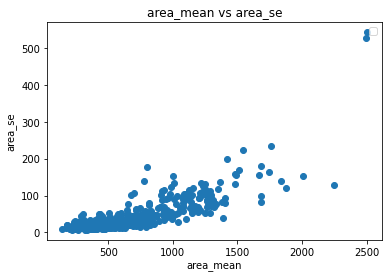

No handles with labels found to put in legend.


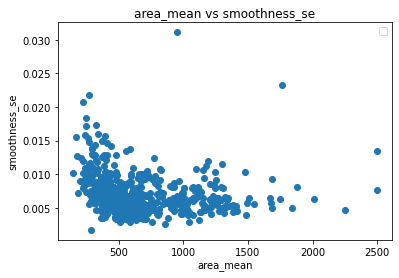

No handles with labels found to put in legend.


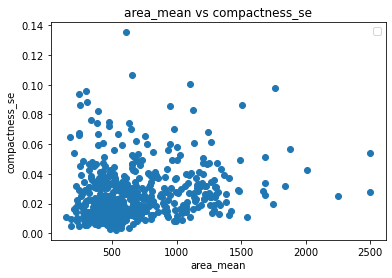

No handles with labels found to put in legend.


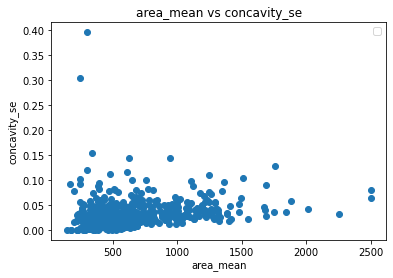

No handles with labels found to put in legend.


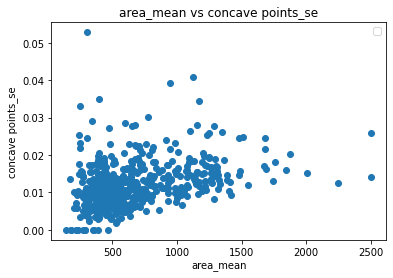

No handles with labels found to put in legend.


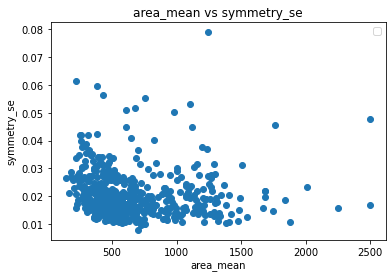

No handles with labels found to put in legend.


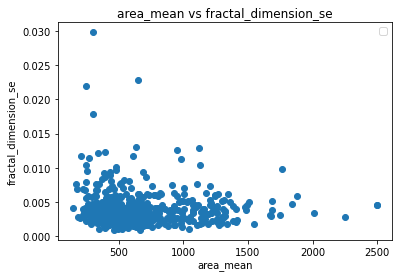

No handles with labels found to put in legend.


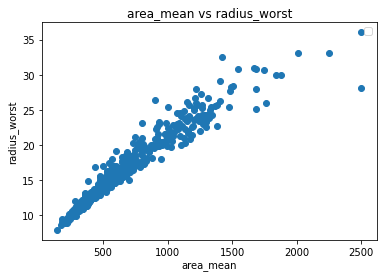

No handles with labels found to put in legend.


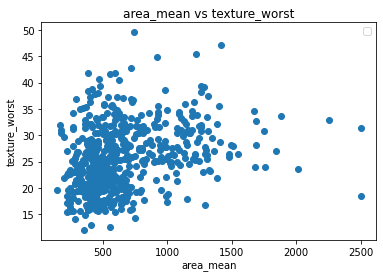

No handles with labels found to put in legend.


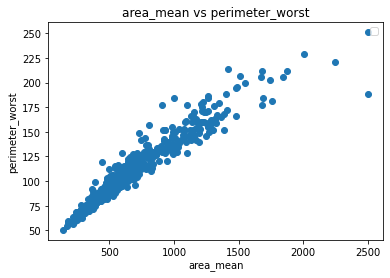

No handles with labels found to put in legend.


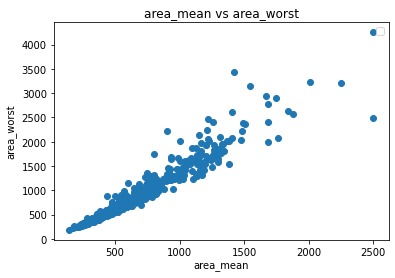

No handles with labels found to put in legend.


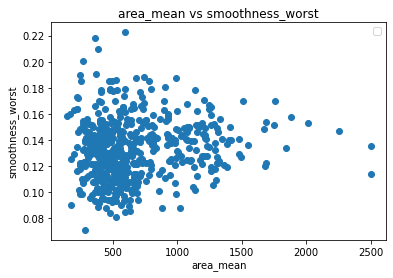

No handles with labels found to put in legend.


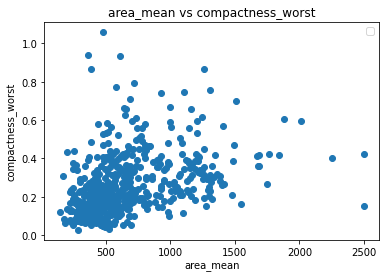

No handles with labels found to put in legend.


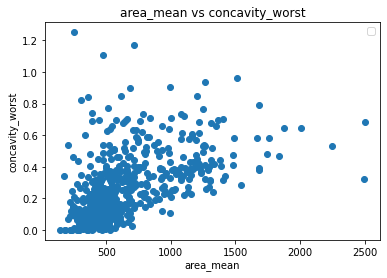

No handles with labels found to put in legend.


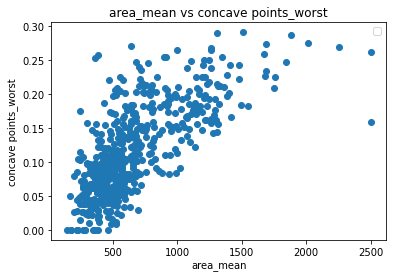

No handles with labels found to put in legend.


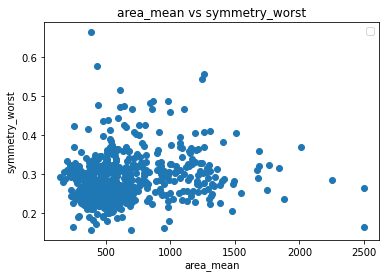

No handles with labels found to put in legend.


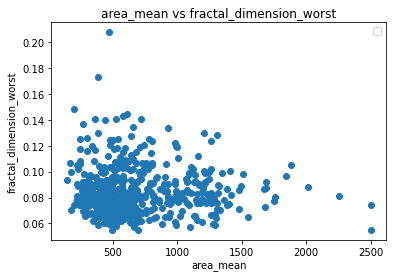

In [511]:
# look at multipl scatter plots for of data set

x_col = 'area_mean'

y_columns = ['id',
 'radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst',
 ]

for y_col in y_columns:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(df[x_col], df[y_col])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(x_col, y_col))

    plt.legend()
    plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


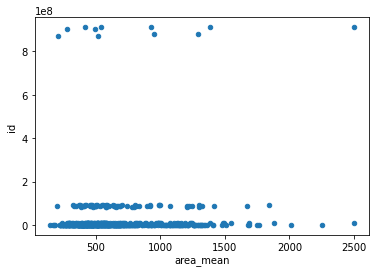

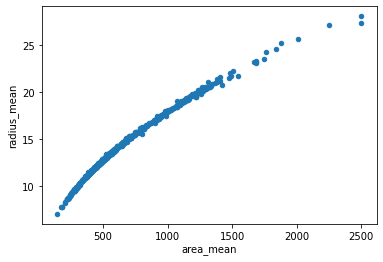

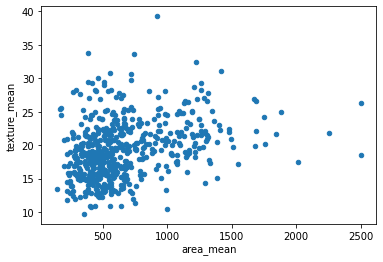

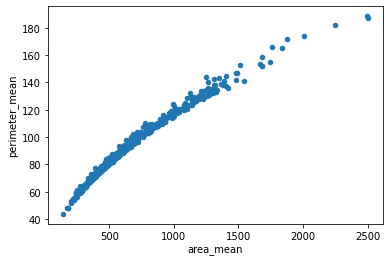

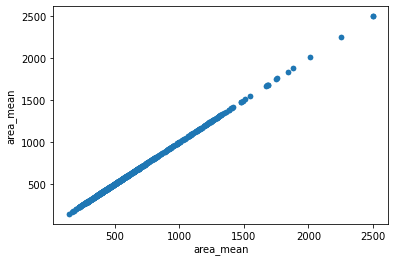

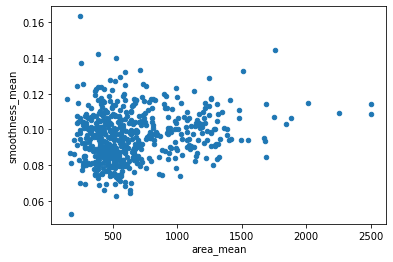

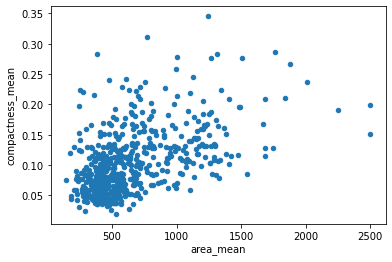

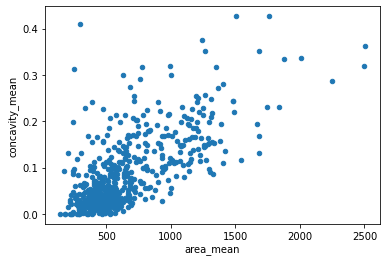

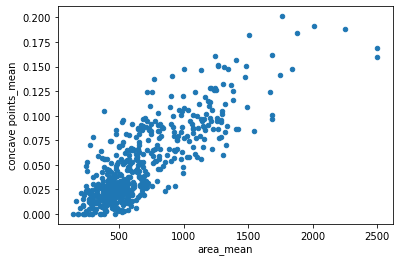

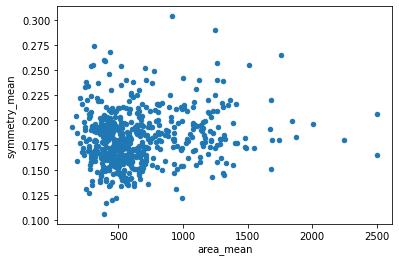

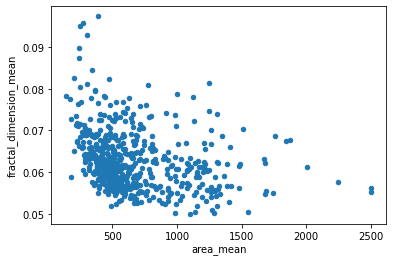

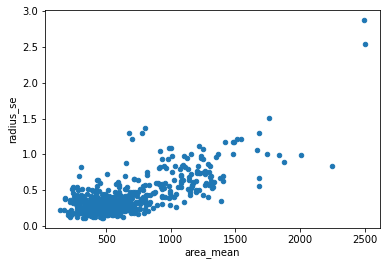

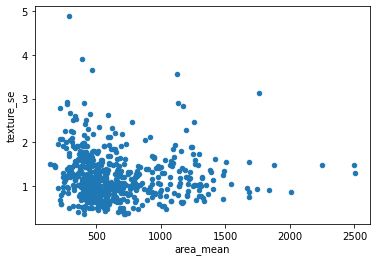

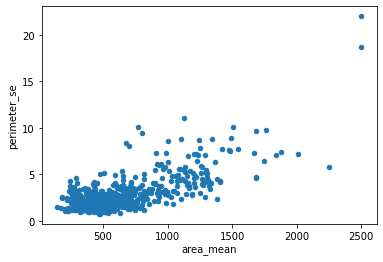

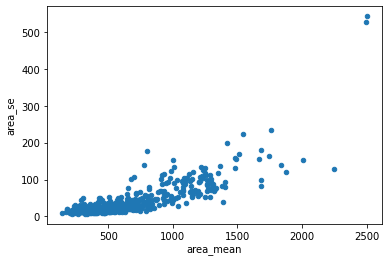

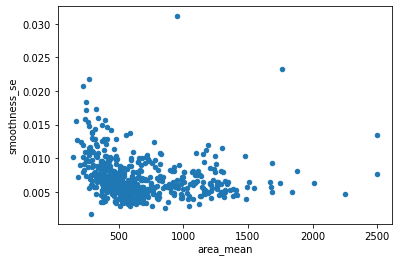

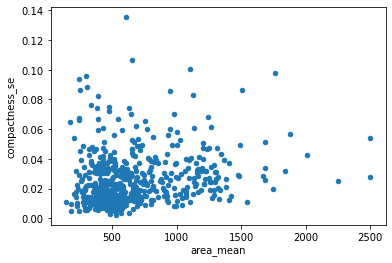

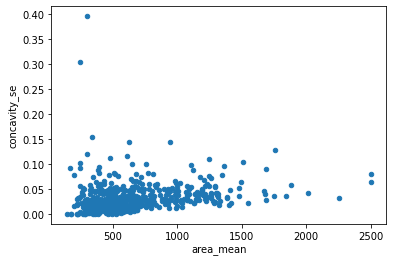

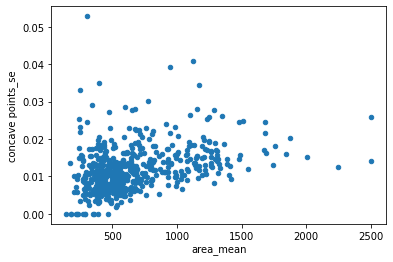

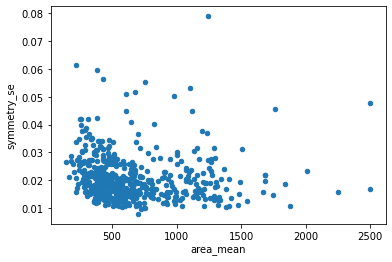

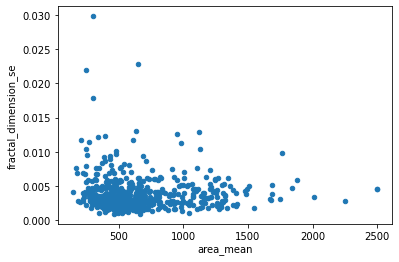

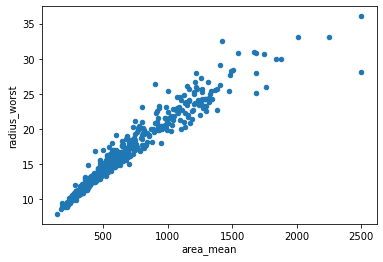

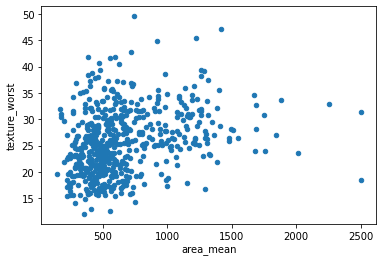

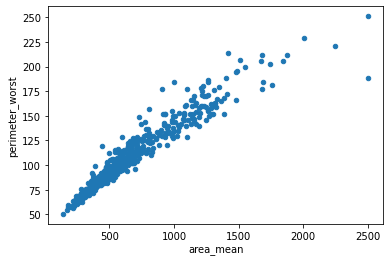

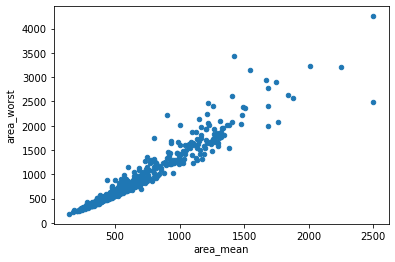

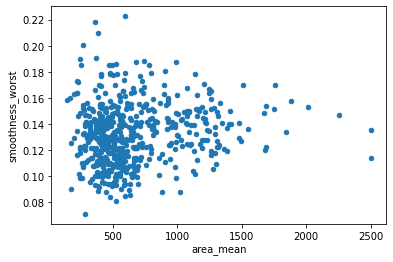

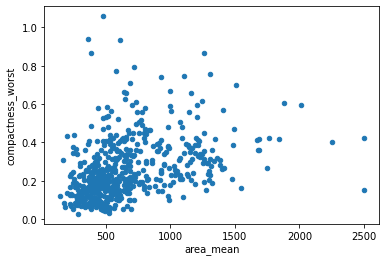

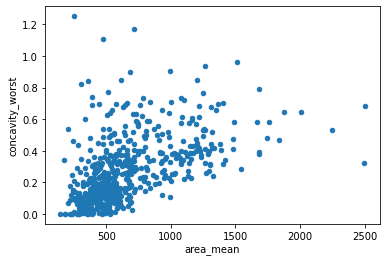

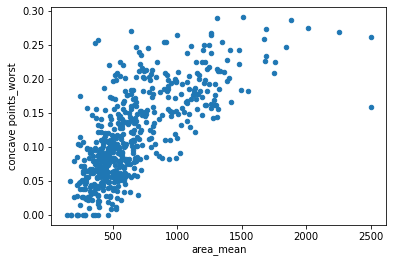

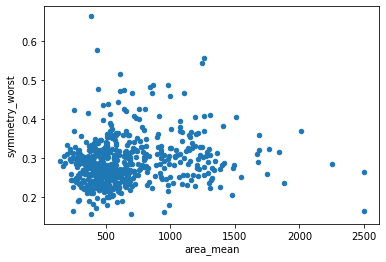

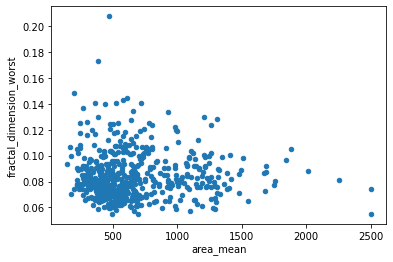

In [512]:
# andys solution for graphing.

for col in df_dropped.columns:
    features = ['area_mean', col]
    df[features].plot(kind='scatter', x=features[0], y=features[1])

In [0]:
# create values for skree graph

sum_of_square_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_dropped)
    sum_of_square_distances.append(km.inertia_)

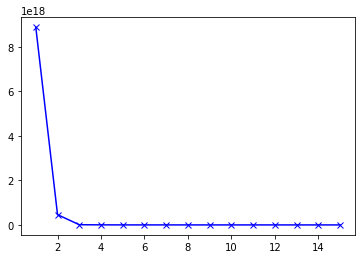

In [514]:
# plot elbow

plt.plot(K, sum_of_square_distances, 'bx-')

In [0]:
# create df for kmeans 

df_model = pd.DataFrame(df_model)
df_model = df['area_mean'], df['smoothness_mean']

In [0]:
# set array to pandas data frame

df_model = pd.DataFrame(df_model)

In [0]:
# transpose data

df_model = df_model.T

In [0]:
# instantiated model

model = KMeans(n_clusters=2)

In [519]:
# fit data set 

model.fit(df_model.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# add cluster labels

df_model['cluster'] = model.labels_

In [521]:
# check addition of cluster labels

df_model.head()

,area_mean,smoothness_mean,cluster
0,1001.0,0.11840,1
1,1326.0,0.08474,1
2,1203.0,0.10960,1
3,386.1,0.14250,0
4,1297.0,0.10030,1


In [0]:
# gain cluster centers

centroids = model.cluster_centers_

In [0]:
# set centroids to a data frame

cc = pd.DataFrame(centroids)

In [0]:
#set each cluster to its own color.

my_colors = ['r', 'b']
colors = [my_colors[centroids] for centroids in model.labels_]

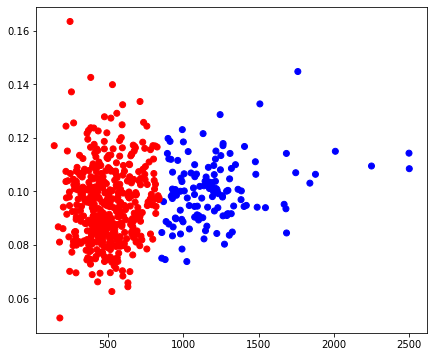

In [525]:
# graph kmeans cluster scatter plot

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(df_model['area_mean'], df_model['smoothness_mean'], c=colors)
ax.scatter(cc[0], cc[1], c=my_colors, s=100)

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [526]:
# Your Code Here

# check how many of each cluster there is

df_model['cluster'].value_counts()

0    445
1    124
Name: cluster, dtype: int64

In [527]:
# check original diagnosis values

df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [0]:
# add diagnosis column to kmodel dataframe

df_model['diagnosis'] = df['diagnosis']

In [0]:
# remap diagnosis values to numeric values

df_model = df_model.replace({'M':0, 'B':1})

In [0]:
# create column that shows where cluster matches diagnosis

df_model['correct'] = np.where(df_model['cluster'] == df_model['diagnosis'], 'yes', 'no')

In [531]:
# check how many are correctly labled

df_model['correct'].value_counts()

no     477
yes     92
Name: correct, dtype: int64

In [532]:
# silhouette score 
from sklearn import metrics
metrics.silhouette_score(df_dropped, model.labels_, metric='euclidean')

0.26460008684141445

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [0]:
##### Your Code Here #####

In [534]:
df_dropped = pd.DataFrame(df_dropped)
df_dropped

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [0]:
# get column labels for later use

features = list(df_dropped.columns)

In [0]:
# call standard scaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [0]:
# scale data

scaled_data = scaler.fit_transform(df_dropped)

In [0]:
# turn scaled data into data frame with original labels

df_scaled = pd.DataFrame(scaled_data, columns=features)

In [0]:
# call PCA and set pca componets to 2

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [0]:
# fit and transform data into 2 componets

pca_features = pca.fit_transform(df_scaled)

In [541]:
pca_features[:5]

array([[ 9.18319983,  1.97127137],
       [ 2.38329766, -3.75345877],
       [ 5.74247239, -1.08035048],
       [ 7.12438398, 10.27222513],
       [ 3.94569386, -1.95968949]])

In [542]:
# check and see how much data is lost

sum(pca.explained_variance_ratio_)

0.6124149284660232

In [0]:
# turn new pca values into data frame 

df_pca = pd.DataFrame(pca_features, columns=['comp_1', 'comp_2'])

In [0]:
# instantiate models with kmeans

k = 2
model = KMeans(n_clusters=k)

In [545]:
# fit kmeans with data

model.fit(df_pca.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# create labels column.

df_pca['clusters'] = model.labels_

In [547]:
df_pca.sample(5)

,comp_1,comp_2,clusters
43,0.983454,0.998343,1
66,-2.791239,2.311588,1
147,0.403294,1.064415,1
150,-1.288123,0.074246,1
200,-1.478430,0.122800,1


In [0]:
# gain centroids

centroids = model.cluster_centers_

In [0]:
cc = pd.DataFrame(centroids)

In [0]:
base_colors  =  ['r', 'b']
colors       =  [base_colors[centroid] for centroid in model.labels_]

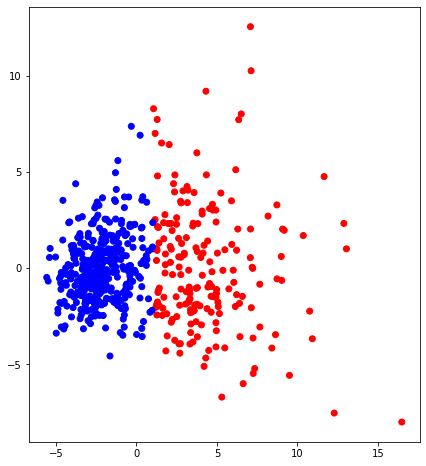

In [551]:
# plot PCA standerdized kmeans

fig, ax = plt.subplots(figsize=(7,8))
ax.scatter(df_pca['comp_1'], df_pca['comp_2'], c=colors)

In [0]:
df_pca['diagnosis'] = df['diagnosis']

In [0]:
df_pca = df_pca.replace({'M':0, 'B':1})

In [0]:
df_pca['correct'] = np.where(df_pca['clusters'] == df_pca['diagnosis'], 'yes', 'no')

In [555]:
df_pca['correct'].value_counts()

yes    516
no      53
Name: correct, dtype: int64

In [556]:
from sklearn import metrics
metrics.silhouette_score(df_dropped, model.labels_, metric='euclidean')

0.10404020171898405

In [0]:
pca = PCA(n_components=15)

In [0]:
pca_features = pca.fit_transform(df_scaled)

In [559]:
# scree plot
num_components = len(pca.explained_variance_ratio_)
num_components

15

In [560]:
ind = np.arange(num_components)
ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [561]:
vals = pca.explained_variance_ratio_
vals

array([0.42864701, 0.18376792, 0.09146436, 0.06391475, 0.05318759,
       0.03982815, 0.0315572 , 0.02166945, 0.01486427, 0.01300429,
       0.01126306, 0.00948034, 0.00842409, 0.00778485, 0.00506367])

<BarContainer object of 15 artists>

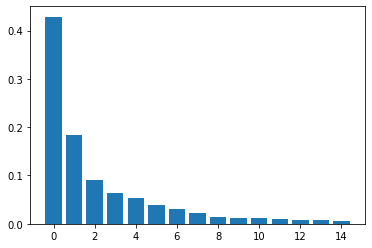

In [562]:
plt.bar(ind, vals)

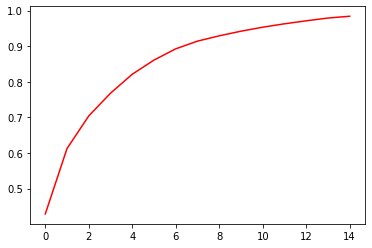

In [563]:
cumvals = np.cumsum(vals)
plt.plot(ind, cumvals, c='r')

In [0]:
def scree_plot(pca):

    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals, c='r')
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

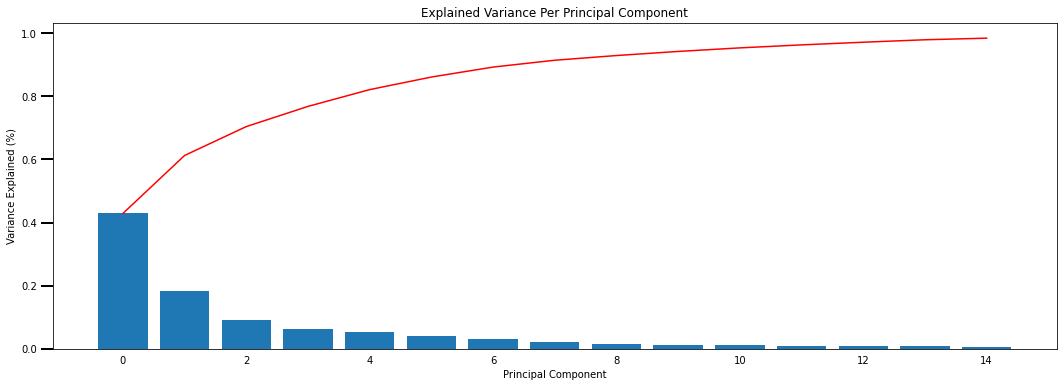

In [565]:
# plot scree

scree_plot(pca)

In [0]:
sum_of_square_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_scaled)
    sum_of_square_distances.append(km.inertia_)

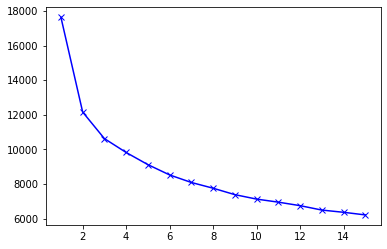

In [567]:
# check elbow for optimul number of dimentions

plt.plot(K, sum_of_square_distances, 'bx-')

In [0]:
pca = PCA(n_components=8)

In [0]:
pca_features = pca.fit_transform(df_scaled)

In [570]:
# explained vatiance ratio > .90

sum(pca.explained_variance_ratio_)

0.9140364266922301

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project